# This is the pipeline using only libraries

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import seaborn as sns 
import pandas as pd

from scipy import sparse
from scipy.sparse import csr_matrix

import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt

import models as m
import utils as u

from surprise.dataset import * 
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import GridSearchCV
%load_ext autoreload
%autoreload 2

## Load data

In [449]:
raw_data = pd.read_csv('data/data_train.csv', header=0, index_col=0, names=['Id', 'rating'])

df = u.preprocess(raw_data).reset_index().drop(columns=['Id'])

# Data Analysis

In [3]:
df.describe()

,rating,user,item
count,1.048575e+06,1.048575e+06,1.048575e+06
mean,3.892523e+00,5.148863e+03,4.291103e+02
std,1.106656e+00,2.919123e+03,2.402626e+02
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,2.603000e+03,2.150000e+02
50%,4.000000e+00,5.244000e+03,4.490000e+02
75%,5.000000e+00,7.735000e+03,6.390000e+02
max,5.000000e+00,9.999000e+03,8.330000e+02


In [4]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.item)))

Total data 
--------------------------------------------------

Total no of ratings : 1048575
Total No of Users   : 10000
Total No of movies  : 834


In [5]:
df.head()

,rating,user,item
0,4,43,0
1,3,60,0
2,4,66,0
3,3,71,0
4,5,85,0


## Number of rating per user

In [6]:
number_of_rating_per_user = df.groupby("user").count().rating.sort_values(ascending=False)
number_of_rating_per_user.describe()

count    10000.000000
mean       104.857500
std         59.048201
min          2.000000
25%         61.000000
50%         94.000000
75%        137.000000
max        433.000000
Name: rating, dtype: float64

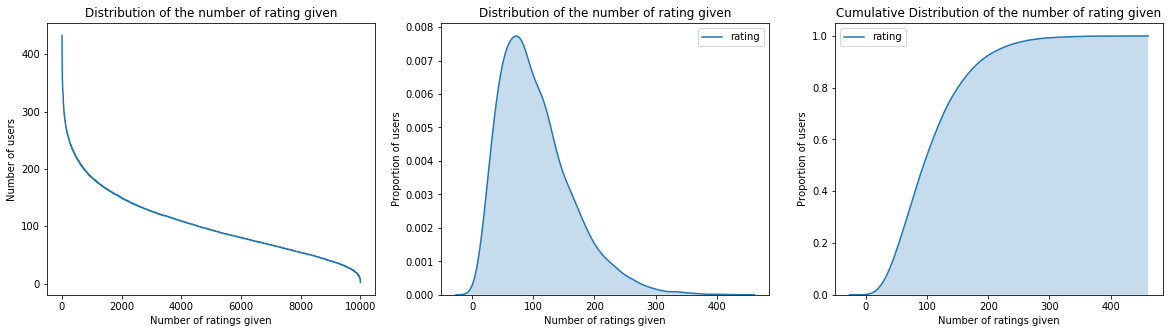

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(number_of_rating_per_user.values)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of users')

plt.subplot(132)
sns.kdeplot(number_of_rating_per_user, shade=True)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of users')

plt.subplot(133)
sns.kdeplot(number_of_rating_per_user, shade=True,cumulative=True,)
plt.title('Cumulative Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of users')

plt.show()

##  Number of rating per movie

In [8]:
number_of_rating_per_movie = df.groupby("item").count().rating.sort_values(ascending=False)
number_of_rating_per_movie.describe()

count     834.000000
mean     1257.284173
std       967.608495
min        27.000000
25%       528.000000
50%       965.000000
75%      1743.750000
max      4590.000000
Name: rating, dtype: float64

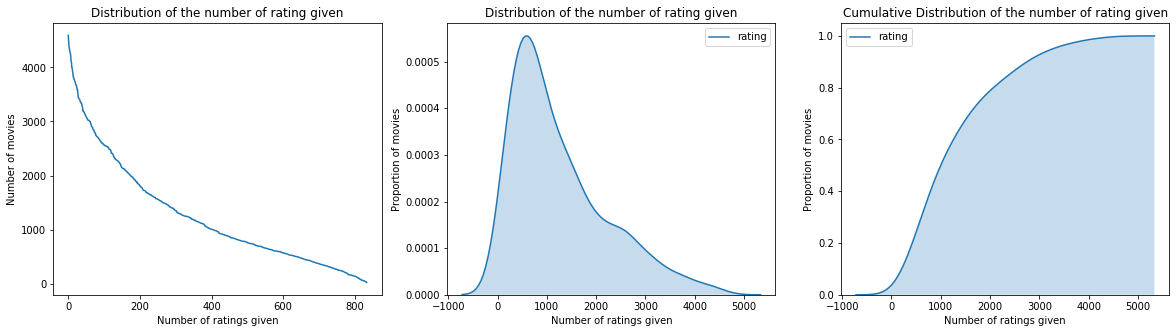

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(number_of_rating_per_movie.values);
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Number of movies')

plt.subplot(132)
sns.kdeplot(number_of_rating_per_movie, shade=True)
plt.title('Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of movies')

plt.subplot(133)
sns.kdeplot(number_of_rating_per_movie, shade=True,cumulative=True,)
plt.title('Cumulative Distribution of the number of rating given')
plt.xlabel('Number of ratings given')
plt.ylabel('Proportion of movies')

plt.show()

Text(0, 0.5, 'Number of rating')

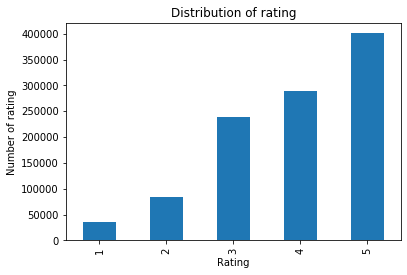

In [10]:
df.groupby('rating').count().user.plot.bar()
plt.title('Distribution of rating')
plt.xlabel('Rating')
plt.ylabel('Number of rating')

## Sparse Matrix 

In [12]:
sparse_matrix = sparse.csr_matrix((df.rating.values, (df.user.values,df.item.values)))
print('Matrix shape is : (user, movie) : ',sparse_matrix.shape)

Matrix shape is : (user, movie) :  (10000, 834)


In [13]:
users, movies = sparse_matrix.shape
elem = sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {0} % ".format((1 - (elem / (users * movies))) * 100))

Sparsity Of Train matrix : 87.4271582733813 % 


## Rating's averages

### Rating's average over all data

In [14]:
global_average = sparse_matrix.sum() / sparse_matrix.count_nonzero()
print("The average rating over all movies is : {0} ".format(global_average) )

The average rating over all movies is : 3.892522709391317 


### Rating's average per user

In [15]:
user_mean = []   #contains the mean rating for user i at index i

for user_index in range(users):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[user_index, :]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            user_mean.append(nonzeros_ratings.mean())
        else:
            user_mean.append(0)

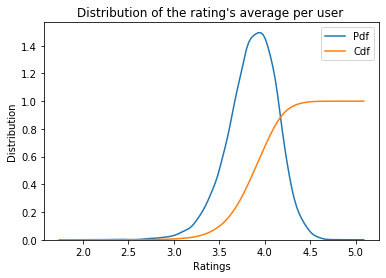

In [16]:
plt.figure()

sns.distplot(user_mean, hist=False,label='Pdf')
sns.distplot(user_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per user ")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Rating's average per movie

In [17]:
movie_mean = []   #contains the mean rating for movie j at index j

for movie_index in range(movies):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[:, movie_index]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            movie_mean.append(nonzeros_ratings.mean())
        else:
            movie_mean.append(0)

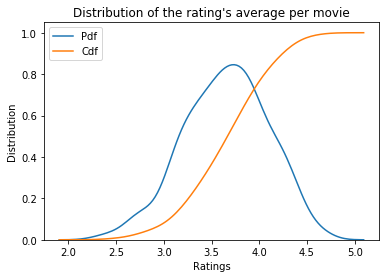

In [18]:
plt.figure()

sns.distplot(movie_mean, hist=False,label='Pdf')
sns.distplot(movie_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per movie")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Similarity Matrix 

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# get the indices of  non zero rows(users) from our sparse matrix
row_ind, col_ind = sparse_matrix.nonzero()

row_ind = sorted(set(row_ind))   #to have unique values and sorted if needed  
col_ind = sorted(set(col_ind))

#### User-User similarity 

In [21]:
top = 5 
print("Computing top",top,"similarities for each user")

Computing top 5 similarities for each user


In [ ]:
user_simil_matrix = []

for row in row_ind: 
    if (row % 1000 == 0):   #to observe the progression as I wait...
        print(row)
        
    # get the similarity row for this user with all other users
    simil = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    
    # get the index of the top 5 
    top_users = np.argsort((simil))[::-1][1:top+1]
    user_simil_matrix.append(top_users)
print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_user_user.txt", user_simil_matrix)
print("Done..")

In [23]:
user_simil_matrix= np.loadtxt("sim_matrix_user_user.txt")
user_simil_matrix

array([[8744., 2649., 2908., 8962., 8367.],
       [7207., 1230., 6780., 2928., 5532.],
       [ 842., 6061., 9924., 1555., 7928.],
       ...,
       [1448., 2774., 1679., 2657., 8170.],
       [5108., 7253., 3210., 3022., 8945.],
       [6615.,  867., 3465., 3809., 1548.]])

#### Movie-Movie similarity

In [24]:
top = 5 
print("Computing top",top,"similarities for each movie")

Computing top 5 similarities for each movie


In [94]:
movie_simil_matrix = []

for col in col_ind: 
    if (col % 100 == 0):   #to observe the progression as I wait...
        print(col)
    
    # get the similarity col for this movie with all other movies
    simil = cosine_similarity(sparse_matrix.getcol(col).T, sparse_matrix.T).ravel()
    # get the index of the top 5 
    top_movies = np.argsort((simil))[::-1][1:top+1]
    movie_simil_matrix.append(top_movies)

print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_movie_movie.txt", movie_simil_matrix)
print("Done..")

0
100
200
300
400
500
600
700
800
Saving it to disk without the need of re-computing it again.. 
Done..


In [25]:
movie_simil_matrix =  np.loadtxt("sim_matrix_movie_movie.txt")
movie_simil_matrix

array([[ 52., 801., 336.,  76., 198.],
       [484., 535., 807., 659., 173.],
       [105., 699., 750., 790., 439.],
       ...,
       [705., 809.,  13., 546., 349.],
       [457., 256.,  13., 349.,  59.],
       [705., 155., 778., 496., 133.]])

### Featurizing data

GAvg : Average rating of all the ratings
    
Similar users rating of this movie:
sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

Similar movies rated by this user:
smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

UAvg : User's Average rating
    
MAvg : Average rating of this movie
    
rating : Rating of this movie by this user.

In [26]:
row_ind, col_ind = sparse_matrix.nonzero()

In [27]:
df_featured_data = pd.DataFrame({'User': row_ind, 'Movie' : col_ind, 'Grade' : sparse_matrix.data, 'Global_Average' : global_average })

In [28]:
df_featured_data.head()

,User,Movie,Grade,Global_Average
0,0,9,5,3.892523
1,0,60,5,3.892523
2,0,67,4,3.892523
3,0,83,4,3.892523
4,0,205,2,3.892523


In [29]:
df_featured_data['User_Average'] = df_featured_data['User'].map(lambda x: user_mean[x])
df_featured_data['Movie_Average'] = df_featured_data['Movie'].map(lambda x: movie_mean[x])

In [30]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average
0,0,9,5,3.892523,4.2,3.646072
1,0,60,5,3.892523,4.2,3.884834
2,0,67,4,3.892523,4.2,3.505051
3,0,83,4,3.892523,4.2,4.175318
4,0,205,2,3.892523,4.2,3.974499


Get the indices of the similar users

In [ ]:
df_featured_data['SimUser1'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_featured_data['SimUser2'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_featured_data['SimUser3'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_featured_data['SimUser4'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_featured_data['SimUser5'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [489]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.2,3.646072,8744,2649,2908,8962,8367,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.2,3.884834,8744,2649,2908,8962,8367,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.2,3.505051,8744,2649,2908,8962,8367,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.2,4.175318,8744,2649,2908,8962,8367,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.2,3.974499,8744,2649,2908,8962,8367,4.668212,4.345068,4.493464,4.365132,4.561553


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [490]:
def Userfunction1(row):
    if(sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [491]:
df_featured_data['SimUser1'] = df_featured_data.apply(Userfunction1,axis=1)

In [492]:
def Userfunction2(row):
    if(sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [493]:
df_featured_data['SimUser2'] = df_featured_data.apply(Userfunction2,axis=1)

In [494]:
def Userfunction3(row):
    if(sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [495]:
df_featured_data['SimUser3'] = df_featured_data.apply(Userfunction3,axis=1)

In [496]:
def Userfunction4(row):
    if(sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [497]:
df_featured_data['SimUser4'] = df_featured_data.apply(Userfunction4,axis=1)

In [498]:
def Userfunction5(row):
    if(sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [499]:
df_featured_data['SimUser5'] = df_featured_data.apply(Userfunction5,axis=1)

In [500]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.200000,3.646072,5.000000,3.837209,4.148515,3.958333,4.100000,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.200000,3.884834,3.000000,4.000000,4.148515,5.000000,4.100000,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.200000,3.505051,3.966667,3.837209,3.000000,3.958333,4.000000,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.200000,4.175318,3.966667,3.837209,3.000000,4.000000,4.100000,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.200000,3.974499,3.966667,3.837209,4.148515,3.958333,4.100000,4.668212,4.345068,4.493464,4.365132,4.561553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,9999,768,3,3.892523,4.030612,4.183138,4.000000,3.966667,3.818182,5.000000,5.000000,4.443052,4.000000,4.327196,4.000000,4.206940
1048571,9999,790,4,3.892523,4.030612,4.243106,5.000000,3.966667,3.818182,4.225166,5.000000,2.000000,5.000000,4.493464,4.691840,4.726254
1048572,9999,791,5,3.892523,4.030612,4.235588,4.105882,5.000000,5.000000,5.000000,5.000000,5.000000,4.410410,4.493441,4.448840,2.000000
1048573,9999,793,3,3.892523,4.030612,3.903812,4.105882,3.966667,3.818182,4.225166,3.000000,3.000000,4.394074,5.000000,4.000000,4.354707


Get the indices of the similar movies

In [366]:
df_featured_data['SimMovie1'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_featured_data['SimMovie2'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_featured_data['SimMovie3'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_featured_data['SimMovie4'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_featured_data['SimMovie5'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

In [367]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.2,3.646072,5.000000,3.837209,4.148515,3.958333,4.1,155,5,607,45,595
1,0,60,5,3.892523,4.2,3.884834,5.000000,5.000000,4.148515,5.000000,4.1,593,595,255,433,13
2,0,67,4,3.892523,4.2,3.505051,3.966667,3.837209,4.000000,3.958333,4.0,59,155,88,284,610
3,0,83,4,3.892523,4.2,4.175318,3.966667,3.837209,4.000000,4.000000,4.1,546,250,190,160,59
4,0,205,2,3.892523,4.2,3.974499,3.966667,3.837209,4.148515,3.958333,4.1,155,294,177,494,59


For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [368]:
def Moviefunction1(row):
    if(sparse_matrix[row['User'],row['SimMovie1']] == 0):
        return movie_mean[int(row['SimMovie1'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie1']]

In [369]:
df_featured_data['SimMovie1'] = df_featured_data.apply(Moviefunction1,axis=1)

In [370]:
def Moviefunction2(row):
    if(sparse_matrix[row['User'],row['SimMovie2']] == 0):
        return movie_mean[int(row['SimMovie2'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie2']]

In [371]:
df_featured_data['SimMovie2'] = df_featured_data.apply(Moviefunction2,axis=1)

In [374]:
def Moviefunction3(row):
    if(sparse_matrix[row['User'],row['SimMovie3']] == 0):
        return movie_mean[int(row['SimMovie3'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie3']]

In [375]:
df_featured_data['SimMovie3'] = df_featured_data.apply(Moviefunction3,axis=1)

In [376]:
def Moviefunction4(row):
    if(sparse_matrix[row['User'],row['SimMovie4']] == 0):
        return movie_mean[int(row['SimMovie4'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie4']]

In [377]:
df_featured_data['SimMovie4'] = df_featured_data.apply(Moviefunction4,axis=1)

In [378]:
def Moviefunction5(row):
    if(sparse_matrix[row['User'],row['SimMovie5']] == 0):
        return movie_mean[int(row['SimMovie5'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie5']]

In [379]:
df_featured_data['SimMovie5'] = df_featured_data.apply(Moviefunction5,axis=1)

We finnaly get the following dataframe with 13 features

In [501]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,9,5,3.892523,4.200000,3.646072,5.000000,3.837209,4.148515,3.958333,4.100000,4.668212,4.682770,4.639421,4.446219,5.000000
1,0,60,5,3.892523,4.200000,3.884834,3.000000,4.000000,4.148515,5.000000,4.100000,4.682035,5.000000,4.726254,4.354707,4.424486
2,0,67,4,3.892523,4.200000,3.505051,3.966667,3.837209,3.000000,3.958333,4.000000,4.561553,4.668212,4.125744,3.953674,4.448840
3,0,83,4,3.892523,4.200000,4.175318,3.966667,3.837209,3.000000,4.000000,4.100000,4.048102,4.358686,4.486889,4.239246,4.561553
4,0,205,2,3.892523,4.200000,3.974499,3.966667,3.837209,4.148515,3.958333,4.100000,4.668212,4.345068,4.493464,4.365132,4.561553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,9999,768,3,3.892523,4.030612,4.183138,4.000000,3.966667,3.818182,5.000000,5.000000,4.443052,4.000000,4.327196,4.000000,4.206940
1048571,9999,790,4,3.892523,4.030612,4.243106,5.000000,3.966667,3.818182,4.225166,5.000000,2.000000,5.000000,4.493464,4.691840,4.726254
1048572,9999,791,5,3.892523,4.030612,4.235588,4.105882,5.000000,5.000000,5.000000,5.000000,5.000000,4.410410,4.493441,4.448840,2.000000
1048573,9999,793,3,3.892523,4.030612,3.903812,4.105882,3.966667,3.818182,4.225166,3.000000,3.000000,4.394074,5.000000,4.000000,4.354707


We save the dataframe computed

In [32]:
file_name = 'featured_data.pk'
df_featured_data.to_pickle(file_name)  

# XGB with 13 features

### Training

In [35]:
df = pd.read_pickle(file_name)

In [37]:
import xgboost as xgb

In [38]:
def error_metrics(true,pred):
    rmse = np.sqrt(np.mean([ (true[i] - pred[i])**2 for i in range(len(pred)) ]))
    mape = np.mean(np.abs( (true-pred)/true ))*100
    return rmse, mape

In [506]:
algo = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=1, n_estimators=100)

x_train= df.drop(['User','Movie','Grade'],axis=1)
y_train= df['Grade']

algo.fit(x_train, y_train, eval_metric = 'rmse')
y_train_pred = algo.predict(x_train)
rmse_train, mape_train = error_metrics(y_train.values, y_train_pred)
train_r = {'rmse': rmse_train,'mape' : mape_train,'predictions' : y_train_pred}

C:\Users\Ridha\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Ridha\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:08:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [507]:
train_r

{'rmse': 0.9649037962541899,
 'mape': 27.94645721556277,
 'predictions': array([3.981151 , 4.246266 , 3.7017262, ..., 4.5438004, 3.802572 ,
        3.5928674], dtype=float32)}

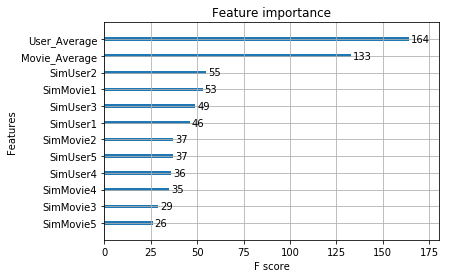

In [508]:
xgb.plot_importance(algo)
plt.show()

### Prediciton

We read the data and put it in a sparse matrix

In [606]:
ids, users , movies=  u.read_file()

In [460]:
pred_users_set = sorted(set(users))

In [458]:
pred_movies_set = sorted(set(movies))

In [449]:
print( "In submission file we have {0} users and {1} movies".format(len(set(users)),len(set(movies))))

In submission file we have 10000 users and 1000 movies


In [510]:
max(pred_users_set)

9999

In [459]:
pred_users_set.difference(row_ind)

set()

In [512]:
new_movies = pred_movies_set.difference(col_ind)
len(new_movies)

166

We have to predict ratings for movies that are not in our training set 

Featurizing the data

In [450]:
df_sub = pd.DataFrame({"User" : users, "Movie" : movies, "Global_Average" : global_average})

In [451]:
df_sub.head()

,User,Movie,Global_Average
0,36,0,3.892523
1,72,0,3.892523
2,155,0,3.892523
3,159,0,3.892523
4,247,0,3.892523


In [462]:
df_sub['User_Average'] = df_sub['User'].map(lambda x: user_mean[x])

In [514]:
def movie_average_function(row):
    if(row.Movie not in new_movies):
        return movie_mean[int(row.Movie)]
    else: 
        return global_average    #if we don't know the movie we put the average rating 

In [515]:
df_sub['Movie_Average'] = df_sub.apply(movie_average_function, axis=1)

In [516]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,36,0,3.892523,3.732558,3.379412,3129,7951,3819,9538,8531
1,72,0,3.892523,3.539326,3.379412,4933,4,6852,8338,8051
2,155,0,3.892523,4.276860,3.379412,5901,6100,9406,823,2889
3,159,0,3.892523,3.746212,3.379412,5288,999,1984,5855,742
4,247,0,3.892523,3.899329,3.379412,5848,2356,5307,3227,5705


We get the user that are similar 

In [480]:
df_sub['SimUser1'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_sub['SimUser2'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_sub['SimUser3'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_sub['SimUser4'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_sub['SimUser5'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [482]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,36,0,3.892523,3.732558,3.379412,3129,7951,3819,9538,8531
1,72,0,3.892523,3.539326,3.379412,4933,4,6852,8338,8051
2,155,0,3.892523,4.276860,3.379412,5901,6100,9406,823,2889
3,159,0,3.892523,3.746212,3.379412,5288,999,1984,5855,742
4,247,0,3.892523,3.899329,3.379412,5848,2356,5307,3227,5705


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [520]:
def PredUserfunction1(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [521]:
df_sub['SimUser1'] = df_sub.apply(PredUserfunction1,axis=1)

In [522]:
def PredUserfunction2(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [523]:
df_sub['SimUser2'] = df_sub.apply(PredUserfunction2,axis=1)

In [524]:
def PredUserfunction3(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [525]:
df_sub['SimUser3'] = df_sub.apply(PredUserfunction3,axis=1)

In [528]:
def PredUserfunction4(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [529]:
df_sub['SimUser4'] = df_sub.apply(PredUserfunction4,axis=1)

In [530]:
def PredUserfunction5(row):
    if(row.Movie in new_movies or sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [531]:
df_sub['SimUser5'] = df_sub.apply(PredUserfunction5,axis=1)

In [ ]:
df_sub.head()

We now get the movies that are similar but here we have the problem that we have missing movies sometimes so we put the average rating as an estimator. 

In [544]:
def movie_function1(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie1 = int(movie_simil_matrix[int(row.Movie)][0])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie1] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie1]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie1]  

In [545]:
df_sub['SimMovie1'] = df_sub.apply(movie_function1, axis=1)

In [548]:
def movie_function2(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie2 = int(movie_simil_matrix[int(row.Movie)][1])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie2] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie2]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie2]  

In [549]:
df_sub['SimMovie2'] = df_sub.apply(movie_function2, axis=1)

In [552]:
def movie_function3(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie3 = int(movie_simil_matrix[int(row.Movie)][2])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie3] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie3]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie3]  

In [553]:
df_sub['SimMovie3'] = df_sub.apply(movie_function3, axis=1)

In [554]:
def movie_function4(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie4 = int(movie_simil_matrix[int(row.Movie)][3])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie4] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie4]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie4]  

In [558]:
df_sub['SimMovie4'] = df_sub.apply(movie_function4, axis=1)

In [556]:
def movie_function5(row):
    if(row.Movie in new_movies):   #if new_movie
        return global_average
    else:
        
        index_movie5 = int(movie_simil_matrix[int(row.Movie)][4])   #get index of similar movie
        
        if(sparse_matrix[row['User'],index_movie5] == 0):     #if not graded by the user give the movie mean rating
            return movie_mean[index_movie5]
        else:                                                 #if graded by the user 
            return sparse_matrix[row['User'],index_movie5]  

In [559]:
df_sub['SimMovie5'] = df_sub.apply(movie_function5, axis=1)

I save the data featurized

In [594]:
file_name_pred = 'featured_data_pred.pk'
df_sub.to_pickle(file_name_pred)  

In [230]:
df_sub_load_on_full_dataset= pd.read_pickle(file_name_pred)

In [231]:
df_sub_load_on_full_dataset.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,36,0,3.892523,3.732558,3.379412,3.000000,3.537313,4.121739,3.000000,3.983193,4.000000,4.002893,3.971499,3.240566,3.240566
1,72,0,3.892523,3.539326,3.379412,3.775701,3.983193,3.587786,4.073913,4.157143,3.774063,4.002893,3.000000,3.240566,3.240566
2,155,0,3.892523,4.276860,3.379412,2.000000,4.150602,4.059925,4.251256,3.581522,4.000000,4.002893,3.000000,3.240566,3.240566
3,159,0,3.892523,3.746212,3.379412,4.000000,4.107817,4.464286,4.231023,4.000000,3.774063,4.002893,3.000000,3.240566,3.240566
4,247,0,3.892523,3.899329,3.379412,4.104265,3.000000,2.000000,4.307463,4.065934,3.774063,4.002893,3.971499,3.240566,3.240566


In [229]:
df_sub_load_on_full_dataset = df_sub_load_on_full_dataset.drop(['User','Movie'],axis =1 )

In [598]:
y_pred = algo.predict(df_sub_load_on_full_dataset)

In [603]:
y_pred_rounded = []
for i in y_pred:
    y_pred_rounded.append(int(round(i)))

In [608]:
u.create_csv_submission(ids,y_pred_rounded,"geralsucks.csv")

 This had 1.057 online

## Surprise models

## Load data

In [450]:
raw_data = pd.read_csv('data/data_train.csv', header=0, index_col=0, names=['Id', 'rating'])

data = u.preprocess(raw_data).reset_index().drop(columns=['Id'])
reader=Reader(rating_scale=(1.0,5.0))
formatted_data= Dataset.load_from_df(data[['user','item','rating']],reader)


## Baseline

In [ ]:
from surprise import BaselineOnly

# bsl_options = {'method': 'als',
#                'n_epochs': 5,
#                'reg_u': 12,
#                'reg_i': 5
#                }
# algoBL = BaselineOnly(bsl_options)
# cross_validate(algoBL, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])

param_grid = {'bsl_options': {'method': ['sgd','als'],
                               'n_epochs': [5,10],
                               'reg_u': [5,15],
                               'reg_i': [5,15]
                               }
              }

gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
bsl_options=gs.best_params['rmse'].get('bsl_options')
# {'bsl_options': {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}, 'verbose': True}

In [419]:
bsl_options= {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}
algoBL = BaselineOnly(bsl_options)
cross_validate(algoBL, formatted_data, verbose=True,cv=5, measures=['RMSE'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9870  0.9956  0.9926  0.9901  0.9913  0.9913  0.0028  
Fit time          2.92    2.85    3.01    3.81    3.05    3.13    0.35    
Test time         1.13    0.96    0.94    3.32    1.00    1.47    0.93    


{'test_rmse': array([0.9869675 , 0.99560053, 0.9926459 , 0.9900955 , 0.99128126]),
 'fit_time': (2.917841911315918,
  2.846405267715454,
  3.0086100101470947,
  3.8072359561920166,
  3.0451438426971436),
 'test_time': (1.1283760070800781,
  0.9572129249572754,
  0.9413418769836426,
  3.3152878284454346,
  1.0045089721679688)}

In [422]:
ids, preds = u.predict_on_model(algoBL)
u.create_csv_submission(ids, preds, "submissionBase1.csv")

In [365]:
trainset, testset = train_test_split(formatted_data, test_size=.2)

y_val = []
for a,b,c  in testset:
    y_val.append(c)
df_y_val=pd.DataFrame(y_val)


bsl_options={'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}

print("-Training Baseline")
algoBL=BaselineOnly(bsl_options=bsl_options)
algoBL.fit(trainset)

test_predBL=algoBL.test(testset)
dfBL=df_from_model_pred(test_predBL)

-Training Baseline
Estimating biases using als...


## CoClustering

In [385]:
from surprise import CoClustering

# algoCC = m.co_clustering()

# cross_validate(algoCC, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# RMSE: 0.99 locally, 1.140 online

param_grid = {'n_cltr_u':[2,3,4,5],'n_cltr_i': [2,3,4, 5]}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
# best RMSE parameters
print(gs.best_params['rmse'])
n_cltr_u,n_cltr_i=gs.best_params['rmse'].values()

# {'n_cltr_u': 2, 'n_cltr_i': 4}
# 4    138653
# 3     44228
# 5     24801
# 2      2007
# 1        26
n_cltr_u=2,n_cltr_i=4

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.9991682478951182
{'n_cltr_u': 2, 'n_cltr_i': 4}


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 12.1min finished


In [398]:
algoCC=CoClustering(n_cltr_u=n_cltr_u, n_cltr_i=n_cltr_i)
cross_validate(algoCC, formatted_data, verbose=True,cv=3, measures=['RMSE'])# RMSE: 0.99 locally, 1.140 online


Evaluating RMSE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9983  1.0006  1.0013  1.0001  0.0013  
Fit time          16.19   18.30   17.27   17.25   0.86    
Test time         27.27   1.94    1.95    10.39   11.94   


{'test_rmse': array([0.99828744, 1.00062891, 1.00131232]),
 'fit_time': (16.188231945037842, 18.298757791519165, 17.26529622077942),
 'test_time': (27.270771980285645, 1.9414520263671875, 1.9528579711914062)}

In [401]:
ids, preds = u.predict_on_model(algoCC)
u.create_csv_submission(ids, preds, "submissionCoClusteringInv2.csv")

## SVD

In [390]:
from surprise import SVD


# algo = SVD(n_factors=1000, n_epochs=20, lr_all=0.005,reg_all=0.02)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0276 locally


param_grid = {'n_factors':[800,1000,1200],'n_epochs': [5, 10,20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4], 'verbose':[True]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 0.994 locally, 1.06 online
# (n_factors=20, n_epochs=20, lr_all=0.002,reg_bu=0.1, reg_bi=0.01)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 101.4min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 340.1min finished


0.9981218886886397
{'n_factors': 800, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.2, 'verbose': True}


In [ ]:
n_factorsSVD=20, n_epochsSVD=20, lr_allSVD=0.002,reg_buSVD=0.1, reg_biSVD=0.01

In [430]:
algoSVD = SVD(n_factors=n_factorsSVD, n_epochs=n_epochsSVD, lr_all=lr_allSVD,reg_bu=reg_buSVD, reg_bi=reg_biSVD)
cross_validate(algoSVD, formatted_data, verbose=True,cv=3, measures=['RMSE'])# FOUND RMSE: 1.0276 locally

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9973  0.9992  0.9976  0.9980  0.0008  
Fit time          489.00  494.78  489.83  491.20  2.55    
Test time         6.65    2.83    2.84    4.11    1.80    


{'test_rmse': array([0.99731563, 0.99918901, 0.99760937]),
 'fit_time': (489.00414538383484, 494.776967048645, 489.8258008956909),
 'test_time': (6.650759935379028, 2.8321950435638428, 2.839428186416626)}

In [432]:
ids, preds = u.predict_on_model(algoSVD)
u.create_csv_submission(ids, preds, "submissionSVD2.csv")

In [433]:
ids

['r37_c1',
 'r73_c1',
 'r156_c1',
 'r160_c1',
 'r248_c1',
 'r256_c1',
 'r284_c1',
 'r400_c1',
 'r416_c1',
 'r456_c1',
 'r474_c1',
 'r495_c1',
 'r515_c1',
 'r518_c1',
 'r521_c1',
 'r559_c1',
 'r596_c1',
 'r614_c1',
 'r621_c1',
 'r661_c1',
 'r697_c1',
 'r710_c1',
 'r713_c1',
 'r732_c1',
 'r807_c1',
 'r824_c1',
 'r926_c1',
 'r951_c1',
 'r1000_c1',
 'r1141_c1',
 'r1146_c1',
 'r1157_c1',
 'r1184_c1',
 'r1248_c1',
 'r1258_c1',
 'r1283_c1',
 'r1293_c1',
 'r1309_c1',
 'r1377_c1',
 'r1434_c1',
 'r1494_c1',
 'r1540_c1',
 'r1600_c1',
 'r1634_c1',
 'r1678_c1',
 'r1691_c1',
 'r1788_c1',
 'r1803_c1',
 'r1822_c1',
 'r1922_c1',
 'r1935_c1',
 'r1939_c1',
 'r1985_c1',
 'r2068_c1',
 'r2096_c1',
 'r2102_c1',
 'r2192_c1',
 'r2227_c1',
 'r2232_c1',
 'r2236_c1',
 'r2274_c1',
 'r2278_c1',
 'r2280_c1',
 'r2289_c1',
 'r2322_c1',
 'r2331_c1',
 'r2332_c1',
 'r2395_c1',
 'r2405_c1',
 'r2458_c1',
 'r2478_c1',
 'r2489_c1',
 'r2581_c1',
 'r2641_c1',
 'r2713_c1',
 'r2743_c1',
 'r2760_c1',
 'r2787_c1',
 'r2822_c1',
 'r

## SVD++

In [ ]:
from surprise import SVDpp


# algo = SVDpp(verbose=True)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0188 locally, 1.179 online


param_grid = {'n_factors':[800,1000,1200],'n_epochs': [10,20], 'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4], 'verbose':[True]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


In [11]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSVDpp.csv")

## NMF

In [392]:
from surprise import NMF

param_grid = {'n_factors':[15,30],'n_epochs': [20,50], 'reg_pu': [0.02, 0.06],'reg_qi': [0.02, 0.06],'reg_bu': [0.02, 0.06],'reg_bi': [0.02, 0.06]}
algo = NMF(verbose=True)
# cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# FOUND RMSE: 1.0089 locally, 1.142 online

gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3,joblib_verbose=1, n_jobs=-1)
gs.fit(formatted_data)

# best RMSE score
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

# 1.0084120457123176


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.1min


1.0084120457123176
{'n_factors': 15, 'n_epochs': 50, 'reg_pu': 0.06, 'reg_qi': 0.06, 'reg_bu': 0.02, 'reg_bi': 0.06}


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 82.3min finished


In [ ]:
n_factorsNMF= 15, n_epochsNMF= 50, reg_puNMF=0.06, reg_qiNMF= 0.06, reg_buNMF= 0.02, reg_biNMF=0.06

In [9]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionNMF.csv")

## KNN on Movie

In [408]:
import models as m
#use 60
from surprise import KNNBasic


algo =m.movie_knn()
cross_validate(algo, formatted_data, verbose=True,cv=3, measures=['RMSE']) # FOUND RMSE: 1.0603 locally, 1.133 online

# param_grid = {'n_neighbors':[60,100,300],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6],
#               'sim_options':     {
#       'name': ['pearson'],
#       'user_based': [False],
#       'min_support': [10,100]  #minimum number of common use/item to be compared. 
#     }}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

# 1.0604891683598427
# {'n_neighbors': 60, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4, 'sim_options': {'name': 'pearson', 'user_based': False, 'min_support': 10}}
# 4    179645
# 3     27298
# 5      2422
# 2       350

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0522  1.0540  1.0537  1.0533  0.0008  
Fit time          6.86    6.81    7.89    7.18    0.50    
Test time         53.22   52.61   53.86   53.23   0.51    


{'test_rmse': array([1.05221537, 1.05399679, 1.05366749]),
 'fit_time': (6.85510778427124, 6.811979055404663, 7.887862205505371),
 'test_time': (53.222665309906006, 52.60641002655029, 53.863821029663086)}

In [407]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionKNNMovie.csv")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


## KNN on User

In [409]:
#use 300
from surprise import KNNBasic


algoKNNUser =m.user_knn()
cross_validate(algoKNNUser, formatted_data, verbose=True,cv=3, measures=['RMSE', 'MAE'])# RMSE: 1.0196 locally, 1.082 online (new params)

# param_grid = {'n_neighbors':[3,5,9],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)

# # best RMSE score
# print(gs.best_score['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0207  1.0187  1.0195  1.0196  0.0008  
MAE (testset)     0.8144  0.8135  0.8144  0.8141  0.0004  
Fit time          48671.18186.39  169.99  16342.5222859.82
Test time         525.46  504.83  541.66  523.99  15.07   


{'test_rmse': array([1.02065614, 1.01873049, 1.01946552]),
 'test_mae': array([0.81444405, 0.81350765, 0.81435692]),
 'fit_time': (48671.17827582359, 186.38729429244995, 169.99107599258423),
 'test_time': (525.4643251895905, 504.8332440853119, 541.664785861969)}

In [410]:
ids, preds = u.predict_on_model(algoKNNUser)
u.create_csv_submission(ids, preds, "submissionKNNUser1.csv")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


## Slope One

In [ ]:
from surprise import SlopeOne

algo = SlopeOne()
cross_validate(algo, formatted_data, verbose=True,cv=5, measures=['RMSE', 'MAE'])# RMSE: 0.9923 locally, 1.143 online

# param_grid = {}
# gs = GridSearchCV(SlopeOne, param_grid, measures=['rmse', 'mae'], cv=3,joblib_verbose=1, n_jobs=-1)
# gs.fit(formatted_data)
# print(gs.best_score['rmse'])

In [ ]:
ids, preds = u.predict_on_model(algo)
u.create_csv_submission(ids, preds, "submissionSlopeOne.csv")

## Blending

In [451]:
n_factorsNMF= 15
n_epochsNMF= 50
reg_puNMF=0.06
reg_qiNMF= 0.06 
reg_buNMF= 0.02
reg_biNMF=0.06

n_factorsSVD=80
n_epochsSVD=800
lr_allSVD=0.001667
reg_allSVD=0.1

n_cltr_uCC=13
n_cltr_iCC=13
n_epochsCC=200

bsl_options= {'method': 'als', 'n_epochs': 10, 'reg_u': 15, 'reg_i': 5}

model_parameters_user = {
      'name': 'pearson',
      'user_based': True
    }

k_user=100

model_parameters_movie = {
      'name': 'pearson',
      'user_based': False
    }
k_movie=300

In [452]:
def df_from_model_pred(model_pred):
    list=[]
    for pred in model_pred:
#         list.append(int(round(pred.est))) #TODO check if you should round here!!---> Finally decided to round only at the end
        list.append(pred.est)
    return pd.DataFrame(list)


In [453]:
#Split the data
trainset, testset = train_test_split(formatted_data, test_size=.2 ,random_state=1)

In [455]:
dfCC.head()

,0
0,4.057537
1,4.521595
2,4.242008
3,3.901807
4,3.755972


In [454]:
from surprise import BaselineOnly,CoClustering,SVD,SVDpp,NMF, SlopeOne
from surprise import KNNBasic
y_val = []
for a,b,c  in testset:
    y_val.append(c)
df_y_val=pd.DataFrame(y_val)

print("-Training CoCluster")
algoCC= CoClustering(n_cltr_i=n_cltr_iCC, n_cltr_u=n_cltr_uCC, n_epochs=n_epochsCC)
algoCC.fit(trainset)

print("-Training Baseline")
algoBL=BaselineOnly(bsl_options=bsl_options)
algoBL.fit(trainset)


print("-Training SVD")
algoSVD=SVD( n_factors=n_factorsSVD, n_epochs=n_epochsSVD, lr_all=lr_allSVD,reg_all=reg_allSVD)
algoSVD.fit(trainset)

print("-Training SVD++")
algoSVDpp = SVDpp(n_factors=n_factorsSVD, n_epochs=30, lr_all=lr_allSVD,reg_all=reg_allSVD,verbose=True)
algoSVDpp.fit(trainset)

print("-Training NMF")
algoNMF = NMF(n_factors=n_factorsNMF, n_epochs=n_epochsNMF, reg_pu=reg_puNMF, reg_qi=reg_qiNMF, reg_bu=reg_buNMF, reg_bi=reg_biNMF)
algoNMF.fit(trainset)

print("-Training KNN on movie")
algoKNNMovie =KNNBasic(model_parameters=model_parameters_movie, k=k_movie)
algoKNNMovie.fit(trainset)

print("-Training KNN on user")
algoKNNUser =KNNBasic(model_parameters=model_parameters_user,k=k_user)
algoKNNUser.fit(trainset)

print("-Training Slope One")
algoSO = SlopeOne()
algoSO.fit(trainset)

test_predCC=algoCC.test(testset)
dfCC=df_from_model_pred(test_predCC)

test_predBL=algoBL.test(testset)
dfBL=df_from_model_pred(test_predBL)

test_predSVD=algoSVD.test(testset)
dfSVD=df_from_model_pred(test_predSVD)

test_predSVDpp=algoSVDpp.test(testset)
dfSVDpp=df_from_model_pred(test_predSVDpp)

test_predNMF=algoNMF.test(testset)
dfNMF=df_from_model_pred(test_predNMF)

test_predKNNMovie=algoKNNMovie.test(testset)
dfKNNMovie=df_from_model_pred(test_predKNNMovie)

test_predKNNUser=algoKNNUser.test(testset)
dfKNNUser=df_from_model_pred(test_predKNNUser)

test_predSO=algoSO.test(testset)
dfSO=df_from_model_pred(test_predSO)

-Training CoCluster


KeyboardInterrupt: 

In [418]:
df_trainset=[]

for u,m,r in trainset.all_ratings():
    df_trainset.append([u,m,r])
    
df_trainset =pd.DataFrame(df_trainset)
df_trainset = df_trainset.rename({0:'User',1:'Movie',2:'Rating'},axis =1)
df_trainset.head()

,User,Movie,Rating
0,0,0,4.0
1,0,674,2.0
2,0,734,5.0
3,0,317,3.0
4,0,46,3.0


In [128]:
df_trainset.shape

(838860, 3)

## Sparse Matrix 

In [77]:
sparse_matrix = sparse.csr_matrix((df_trainset.Rating.values, (df_trainset.User.values,df_trainset.Movie.values)))
print('Matrix shape is : (user, movie) : ',sparse_matrix.shape)

Matrix shape is : (user, movie) :  (10000, 834)


In [78]:
users, movies = sparse_matrix.shape
elem = sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {0} % ".format((1 - (elem / (users * movies))) * 100))

Sparsity Of Train matrix : 89.94172661870503 % 


## Rating's averages

### Rating's average over all data

In [79]:
global_average = sparse_matrix.sum() / sparse_matrix.count_nonzero()
print("The average rating over all movies is : {0} ".format(global_average) )

The average rating over all movies is : 3.8921083375056624 


### Rating's average per user

In [80]:
user_mean = []   #contains the mean rating for user i at index i

for user_index in range(users):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[user_index, :]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            user_mean.append(nonzeros_ratings.mean())
        else:
            user_mean.append(0)

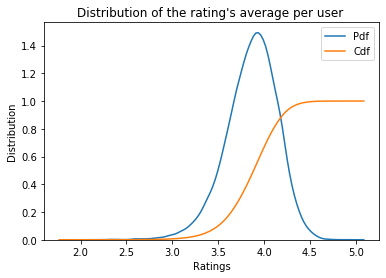

In [81]:
plt.figure()

sns.distplot(user_mean, hist=False,label='Pdf')
sns.distplot(user_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per user ")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Rating's average per movie

In [82]:
movie_mean = []   #contains the mean rating for movie j at index j

for movie_index in range(movies):
    
        # find the non-zero ratings for each user in the dataset
        ratings = sparse_matrix[:, movie_index]
        nonzeros_ratings = ratings[ratings.nonzero()]
        
        # calculate the mean if the number of elements is not 0
        if nonzeros_ratings.shape[1] != 0:
            movie_mean.append(nonzeros_ratings.mean())
        else:
            movie_mean.append(0)

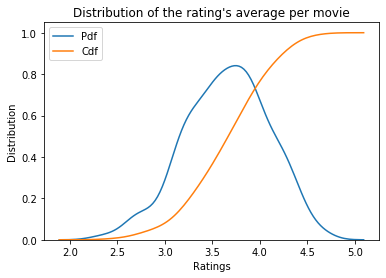

In [83]:
plt.figure()

sns.distplot(movie_mean, hist=False,label='Pdf')
sns.distplot(movie_mean,hist=False, kde_kws=dict(cumulative=True), label='Cdf')

plt.title("Distribution of the rating's average per movie")
plt.xlabel('Ratings')
plt.ylabel('Distribution')

plt.show()

### Similarity Matrix 

In [84]:
from sklearn.metrics.pairwise import cosine_similarity

# get the indices of  non zero rows(users) from our sparse matrix
row_ind, col_ind = sparse_matrix.nonzero()

row_ind = sorted(set(row_ind))   #to have unique values and sorted if needed  
col_ind = sorted(set(col_ind))

#### User-User similarity 

In [85]:
top = 5 
print("Computing top",top,"similarities for each user")

Computing top 5 similarities for each user


In [86]:
user_simil_matrix = []

for row in row_ind: 
    if (row % 1000 == 0):   #to observe the progression as I wait...
        print(row)
        
    # get the similarity row for this user with all other users
    simil = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
    
    # get the index of the top 5 
    top_users = np.argsort((simil))[::-1][1:top+1]
    user_simil_matrix.append(top_users)
print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_user_user_trainset.txt", user_simil_matrix)
print("Done..")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Saving it to disk without the need of re-computing it again.. 
Done..


In [87]:
user_simil_matrix= np.loadtxt("sim_matrix_user_user_trainset.txt")
user_simil_matrix

array([[2092., 3794., 5565., 6375., 2218.],
       [1660., 1860., 2510.,  206.,   69.],
       [3101.,  509., 2635., 9586.,  482.],
       ...,
       [2574., 6942., 5498., 8910., 2168.],
       [9467., 7705., 8130., 9419., 9973.],
       [9985.,  820., 2953., 4898., 8404.]])

#### Movie-Movie similarity

In [88]:
top = 5 
print("Computing top",top,"similarities for each movie")

Computing top 5 similarities for each movie


In [89]:
movie_simil_matrix = []

for col in col_ind: 
    if (col % 100 == 0):   #to observe the progression as I wait...
        print(col)
    
    # get the similarity col for this movie with all other movies
    simil = cosine_similarity(sparse_matrix.getcol(col).T, sparse_matrix.T).ravel()
    # get the index of the top 5 
    top_movies = np.argsort((simil))[::-1][1:top+1]
    movie_simil_matrix.append(top_movies)

print("Saving it to disk without the need of re-computing it again.. ")
np.savetxt("sim_matrix_movie_movie_trainset.txt", movie_simil_matrix)
print("Done..")

0
100
200
300
400
500
600
700
800
Saving it to disk without the need of re-computing it again.. 
Done..


In [90]:
movie_simil_matrix =  np.loadtxt("sim_matrix_movie_movie_trainset.txt")
movie_simil_matrix

array([[313., 695.,  94., 583.,  12.],
       [ 77., 234., 111., 158.,   5.],
       [294., 465.,  55., 264., 194.],
       ...,
       [806., 753., 828., 820., 832.],
       [643., 806., 693., 828., 831.],
       [799., 804., 806., 212., 770.]])

### Featurizing data

GAvg : Average rating of all the ratings
    
Similar users rating of this movie:
sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )

Similar movies rated by this user:
smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )

UAvg : User's Average rating
    
MAvg : Average rating of this movie
    
rating : Rating of this movie by this user.

In [91]:
row_ind, col_ind = sparse_matrix.nonzero()

In [92]:
df_featured_data = pd.DataFrame({'User': row_ind, 'Movie' : col_ind, 'Grade' : sparse_matrix.data, 'Global_Average' : global_average })

In [93]:
df_featured_data.head()

,User,Movie,Grade,Global_Average
0,0,0,4.0,3.892108
1,0,7,4.0,3.892108
2,0,9,3.0,3.892108
3,0,28,5.0,3.892108
4,0,34,5.0,3.892108


In [94]:
df_featured_data['User_Average'] = df_featured_data['User'].map(lambda x: user_mean[x])
df_featured_data['Movie_Average'] = df_featured_data['Movie'].map(lambda x: movie_mean[x])

In [95]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average
0,0,0,4.0,3.892108,3.779661,3.261808
1,0,7,4.0,3.892108,3.779661,4.439823
2,0,9,3.0,3.892108,3.779661,4.116010
3,0,28,5.0,3.892108,3.779661,3.892952
4,0,34,5.0,3.892108,3.779661,4.409139


Get the indices of the similar users

In [96]:
df_featured_data['SimUser1'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_featured_data['SimUser2'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_featured_data['SimUser3'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_featured_data['SimUser4'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_featured_data['SimUser5'] = df_featured_data['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [97]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,0,0,4.0,3.892108,3.779661,3.261808,2092,3794,5565,6375,2218
1,0,7,4.0,3.892108,3.779661,4.439823,2092,3794,5565,6375,2218
2,0,9,3.0,3.892108,3.779661,4.116010,2092,3794,5565,6375,2218
3,0,28,5.0,3.892108,3.779661,3.892952,2092,3794,5565,6375,2218
4,0,34,5.0,3.892108,3.779661,4.409139,2092,3794,5565,6375,2218


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [98]:
def Userfunction1(row):
    if(sparse_matrix[row['SimUser1'],row['Movie']] == 0):
        return user_mean[int(row['SimUser1'])]
    else:
        return sparse_matrix[row['SimUser1'],row['Movie']]

In [99]:
df_featured_data['SimUser1'] = df_featured_data.apply(Userfunction1,axis=1)

In [100]:
def Userfunction2(row):
    if(sparse_matrix[row['SimUser2'],row['Movie']] == 0):
        return user_mean[int(row['SimUser2'])]
    else:
        return sparse_matrix[row['SimUser2'],row['Movie']]

In [101]:
df_featured_data['SimUser2'] = df_featured_data.apply(Userfunction2,axis=1)

In [102]:
def Userfunction3(row):
    if(sparse_matrix[row['SimUser3'],row['Movie']] == 0):
        return user_mean[int(row['SimUser3'])]
    else:
        return sparse_matrix[row['SimUser3'],row['Movie']]

In [103]:
df_featured_data['SimUser3'] = df_featured_data.apply(Userfunction3,axis=1)

In [104]:
def Userfunction4(row):
    if(sparse_matrix[row['SimUser4'],row['Movie']] == 0):
        return user_mean[int(row['SimUser4'])]
    else:
        return sparse_matrix[row['SimUser4'],row['Movie']]

In [105]:
df_featured_data['SimUser4'] = df_featured_data.apply(Userfunction4,axis=1)

In [106]:
def Userfunction5(row):
    if(sparse_matrix[row['SimUser5'],row['Movie']] == 0):
        return user_mean[int(row['SimUser5'])]
    else:
        return sparse_matrix[row['SimUser5'],row['Movie']]

In [107]:
df_featured_data['SimUser5'] = df_featured_data.apply(Userfunction5,axis=1)

In [108]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,0,0,4.0,3.892108,3.779661,3.261808,4.16757,3.76471,4.07101,3.95425,4.1619
1,0,7,4.0,3.892108,3.779661,4.439823,4.16757,3.76471,5.0,3.95425,4.0
2,0,9,3.0,3.892108,3.779661,4.116010,5.0,4.0,5.0,3.95425,4.1619
3,0,28,5.0,3.892108,3.779661,3.892952,5.0,5.0,4.07101,3.95425,4.1619
4,0,34,5.0,3.892108,3.779661,4.409139,5.0,5.0,5.0,5.0,4.0
5,0,44,5.0,3.892108,3.779661,4.413405,5.0,5.0,4.07101,5.0,5.0
6,0,46,3.0,3.892108,3.779661,4.220687,5.0,3.76471,4.07101,5.0,4.1619
7,0,54,5.0,3.892108,3.779661,4.464453,4.16757,4.0,5.0,3.95425,4.1619
8,0,58,5.0,3.892108,3.779661,3.907018,4.16757,3.76471,4.0,3.95425,4.1619
9,0,63,4.0,3.892108,3.779661,2.992296,4.16757,3.76471,4.07101,3.95425,4.1619


Get the indices of the similar movies

In [109]:
df_featured_data['SimMovie1'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_featured_data['SimMovie2'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_featured_data['SimMovie3'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_featured_data['SimMovie4'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_featured_data['SimMovie5'] = df_featured_data['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

In [110]:
df_featured_data.head()

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,0,4.0,3.892108,3.779661,3.261808,4.16757,3.76471,4.07101,3.95425,4.1619,313,695,94,583,12
1,0,7,4.0,3.892108,3.779661,4.439823,4.16757,3.76471,5.0,3.95425,4.0,54,267,15,205,61
2,0,9,3.0,3.892108,3.779661,4.116010,5.0,4.0,5.0,3.95425,4.1619,167,294,34,222,124
3,0,28,5.0,3.892108,3.779661,3.892952,5.0,5.0,4.07101,3.95425,4.1619,134,301,94,350,267
4,0,34,5.0,3.892108,3.779661,4.409139,5.0,5.0,5.0,5.0,4.0,15,75,86,98,84


For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [111]:
def Moviefunction1(row):
    if(sparse_matrix[row['User'],row['SimMovie1']] == 0):
        return movie_mean[int(row['SimMovie1'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie1']]

In [112]:
df_featured_data['SimMovie1'] = df_featured_data.apply(Moviefunction1,axis=1)

In [113]:
def Moviefunction2(row):
    if(sparse_matrix[row['User'],row['SimMovie2']] == 0):
        return movie_mean[int(row['SimMovie2'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie2']]

In [114]:
df_featured_data['SimMovie2'] = df_featured_data.apply(Moviefunction2,axis=1)

In [115]:
def Moviefunction3(row):
    if(sparse_matrix[row['User'],row['SimMovie3']] == 0):
        return movie_mean[int(row['SimMovie3'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie3']]

In [116]:
df_featured_data['SimMovie3'] = df_featured_data.apply(Moviefunction3,axis=1)

In [117]:
def Moviefunction4(row):
    if(sparse_matrix[row['User'],row['SimMovie4']] == 0):
        return movie_mean[int(row['SimMovie4'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie4']]

In [118]:
df_featured_data['SimMovie4'] = df_featured_data.apply(Moviefunction4,axis=1)

In [119]:
def Moviefunction5(row):
    if(sparse_matrix[row['User'],row['SimMovie5']] == 0):
        return movie_mean[int(row['SimMovie5'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie5']]

In [120]:
df_featured_data['SimMovie5'] = df_featured_data.apply(Moviefunction5,axis=1)

We finnaly get the following dataframe with 13 features

In [121]:
df_featured_data

,User,Movie,Grade,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,0,0,4.0,3.892108,3.779661,3.261808,4.16757,3.76471,4.07101,3.95425,4.1619,4.0,3.71103,4.55685,3.89298,3.74728
1,0,7,4.0,3.892108,3.779661,4.439823,4.16757,3.76471,5.0,3.95425,4.0,5.0,4.67221,4.64459,5.0,4.53451
2,0,9,3.0,3.892108,3.779661,4.116010,5.0,4.0,5.0,3.95425,4.1619,4.41158,5.0,5.0,5.0,4.3884
3,0,28,5.0,3.892108,3.779661,3.892952,5.0,5.0,4.07101,3.95425,4.1619,4.44406,4.30465,4.55685,4.16322,4.67221
4,0,34,5.0,3.892108,3.779661,4.409139,5.0,5.0,5.0,5.0,4.0,4.64459,4.34982,5.0,4.68333,3.0
5,0,44,5.0,3.892108,3.779661,4.413405,5.0,5.0,4.07101,5.0,5.0,4.32507,4.23827,4.41055,5.0,4.68761
6,0,46,3.0,3.892108,3.779661,4.220687,5.0,3.76471,4.07101,5.0,4.1619,4.0,5.0,5.0,4.34982,4.72546
7,0,54,5.0,3.892108,3.779661,4.464453,4.16757,4.0,5.0,3.95425,4.1619,4.0,4.41055,4.67221,4.53451,4.3884
8,0,58,5.0,3.892108,3.779661,3.907018,4.16757,3.76471,4.0,3.95425,4.1619,4.37391,4.15806,4.34338,5.0,4.30263
9,0,63,4.0,3.892108,3.779661,2.992296,4.16757,3.76471,4.07101,3.95425,4.1619,4.0,5.0,4.0,3.0,5.0


We save the dataframe computed

In [122]:
file_name = 'featured_data_trainset.pk'
df_featured_data.to_pickle(file_name)  


## Predict on the Testset

In [132]:
df_testset=[]

for u,m,r in testset:
    df_testset.append([u,m,r])
    
df_testset =pd.DataFrame(df_testset)
df_testset = df_testset.rename({0:'User',1:'Movie',2:'Rating'},axis =1)
df_testset.head()

,User,Movie,Rating
0,2455,646,5.0
1,4244,130,4.0
2,5166,202,4.0
3,7402,424,3.0
4,3682,485,3.0


In [152]:
pred_users_set = set(df_testset.User)

In [153]:
pred_movies_set = set(df_testset.Movie)

In [154]:
print( "In submission file we have {0} users and {1} movies".format(len(pred_users_set),len(pred_movies_set)))

In submission file we have 9991 users and 834 movies


In [155]:
max(pred_users_set)

9999

In [158]:
row_ind=set(df_trainset.User)
col_ind=set(df_trainset.Movie)

In [159]:
pred_users_set.difference(row_ind)

set()

In [161]:
pred_movies_set.difference(col_ind)

set()

We have to predict ratings for movies that are not in our training set 

Featurizing the data

In [163]:
df_sub = pd.DataFrame({"User" : df_testset.User, "Movie" : df_testset.Movie, "Global_Average" : global_average})

In [164]:
df_sub.head()

,User,Movie,Global_Average
0,2455,646,3.892108
1,4244,130,3.892108
2,5166,202,3.892108
3,7402,424,3.892108
4,3682,485,3.892108


In [165]:
df_sub['User_Average'] = df_sub['User'].map(lambda x: user_mean[x])

In [166]:
df_sub['Movie_Average'] = df_sub['Movie'].map(lambda x: movie_mean[x])

In [167]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average
0,2455,646,3.892108,3.984000,2.787645
1,4244,130,3.892108,3.645669,4.076853
2,5166,202,3.892108,4.011765,3.017316
3,7402,424,3.892108,3.931034,4.067742
4,3682,485,3.892108,3.490909,3.674769


We get the user that are similar 

In [168]:
df_sub['SimUser1'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][0]))
df_sub['SimUser2'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][1]))
df_sub['SimUser3'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][2]))
df_sub['SimUser4'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][3]))
df_sub['SimUser5'] = df_sub['User'].map(lambda x: int(user_simil_matrix[x][4]))

In [169]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,2455,646,3.892108,3.984000,2.787645,2277,5343,3491,465,803
1,4244,130,3.892108,3.645669,4.076853,6776,1030,4666,1076,5379
2,5166,202,3.892108,4.011765,3.017316,1014,3464,1309,3906,8611
3,7402,424,3.892108,3.931034,4.067742,874,9386,4031,2363,4384
4,3682,485,3.892108,3.490909,3.674769,7511,4319,1342,2906,5390


For each similar user need to find the rating that he put for that movie if not available put the average rating of that user as an estimator. 

In [170]:
df_sub['SimUser1'] = df_sub.apply(Userfunction1,axis=1)
df_sub['SimUser2'] = df_sub.apply(Userfunction2,axis=1)
df_sub['SimUser3'] = df_sub.apply(Userfunction3,axis=1)
df_sub['SimUser4'] = df_sub.apply(Userfunction4,axis=1)
df_sub['SimUser5'] = df_sub.apply(Userfunction5,axis=1)

In [171]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5
0,2455,646,3.892108,3.984000,2.787645,4.10687,4.01739,4.02871,4.34307,3.84706
1,4244,130,3.892108,3.645669,4.076853,3.41216,4.0,3.86239,5.0,4.16071
2,5166,202,3.892108,4.011765,3.017316,4.34389,4.14155,3.96943,4.15723,2.0
3,7402,424,3.892108,3.931034,4.067742,3.74468,4.0177,4.08889,3.76471,3.56716
4,3682,485,3.892108,3.490909,3.674769,3.87879,3.85263,4.00746,3.72414,3.72414


In [173]:
df_sub['SimMovie1'] = df_sub['Movie'].map(lambda x: int(movie_simil_matrix[x][0]))
df_sub['SimMovie2'] = df_sub['Movie'].map(lambda x: int(movie_simil_matrix[x][1]))
df_sub['SimMovie3'] = df_sub['Movie'].map(lambda x: int(movie_simil_matrix[x][2]))
df_sub['SimMovie4'] = df_sub['Movie'].map(lambda x: int(movie_simil_matrix[x][3]))
df_sub['SimMovie5'] = df_sub['Movie'].map(lambda x: int(movie_simil_matrix[x][4]))

In [174]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,2455,646,3.892108,3.984000,2.787645,4.10687,4.01739,4.02871,4.34307,3.84706,777,36,64,509,261
1,4244,130,3.892108,3.645669,4.076853,3.41216,4.0,3.86239,5.0,4.16071,208,267,305,6,5
2,5166,202,3.892108,4.011765,3.017316,4.34389,4.14155,3.96943,4.15723,2.0,345,284,449,597,445
3,7402,424,3.892108,3.931034,4.067742,3.74468,4.0177,4.08889,3.76471,3.56716,277,369,324,431,636
4,3682,485,3.892108,3.490909,3.674769,3.87879,3.85263,4.00746,3.72414,3.72414,99,265,94,597,54


For each similar movie we need to find the rating that the user has given to it if not available give the similar movie average rating.  

In [175]:
def Moviefunction1(row):
    if(sparse_matrix[row['User'],row['SimMovie1']] == 0):
        return movie_mean[int(row['SimMovie1'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie1']]

In [176]:
df_sub['SimMovie1'] = df_sub.apply(Moviefunction1,axis=1)

In [177]:
def Moviefunction2(row):
    if(sparse_matrix[row['User'],row['SimMovie2']] == 0):
        return movie_mean[int(row['SimMovie2'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie2']]

In [178]:
df_sub['SimMovie2'] = df_sub.apply(Moviefunction2,axis=1)

In [179]:
def Moviefunction3(row):
    if(sparse_matrix[row['User'],row['SimMovie3']] == 0):
        return movie_mean[int(row['SimMovie3'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie3']]

In [180]:
df_sub['SimMovie3'] = df_sub.apply(Moviefunction3,axis=1)

In [181]:
def Moviefunction4(row):
    if(sparse_matrix[row['User'],row['SimMovie4']] == 0):
        return movie_mean[int(row['SimMovie4'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie4']]

In [182]:
df_sub['SimMovie4'] = df_sub.apply(Moviefunction4,axis=1)

In [183]:
def Moviefunction5(row):
    if(sparse_matrix[row['User'],row['SimMovie5']] == 0):
        return movie_mean[int(row['SimMovie5'])]
    else:
        return sparse_matrix[row['User'],row['SimMovie5']]

In [184]:
df_sub['SimMovie5'] = df_sub.apply(Moviefunction5,axis=1)

We finnaly get the following dataframe with 13 features

In [185]:
df_sub.head()

,User,Movie,Global_Average,User_Average,Movie_Average,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,2455,646,3.892108,3.984000,2.787645,4.10687,4.01739,4.02871,4.34307,3.84706,3.67135,4.07113,4.11476,3.35088,3.55319
1,4244,130,3.892108,3.645669,4.076853,3.41216,4.0,3.86239,5.0,4.16071,4.03377,4.67221,3.0,3.0,3.0
2,5166,202,3.892108,4.011765,3.017316,4.34389,4.14155,3.96943,4.15723,2.0,4.02832,3.24462,3.89542,3.0,4.0
3,7402,424,3.892108,3.931034,4.067742,3.74468,4.0177,4.08889,3.76471,3.56716,3.6841,4.30263,4.26651,4.27586,4.2892
4,3682,485,3.892108,3.490909,3.674769,3.87879,3.85263,4.00746,3.72414,3.72414,3.92495,4.21165,4.55685,1.0,3.0


I save the data featurized

In [186]:
file_name_testset = 'featured_data_testset.pk'
df_sub.to_pickle(file_name_testset)  

In [187]:
df_sub_load= pd.read_pickle(file_name_testset)

In [194]:
df_sub_load.drop(['User','Movie'],inplace=True, axis=1)

In [195]:
df_sub_load.shape

(209715, 13)

## xgboosting case

In [198]:
# for xgboosting
df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO],ignore_index=True,axis=1)
df_val=df_val.rename({0:'dfCC',1:'dfBL',2:'dfSVD',3:'dfSVDpp',4:'dfNMF',5:'dfKNNMovie',6:'dfKNNUser',7:'dfSO'},axis=1)

In [199]:
df_val=pd.concat([df_val,df_sub_load],axis=1)


In [206]:
file_name_full_testset = 'full_testset_pred.pk'
df_val.to_pickle(file_name_full_testset)  


In [207]:
df_val_load= pd.read_pickle(file_name_full_testset)


In [209]:
df_val_load.head()

,dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO,Global_Average,User_Average,...,SimUser1,SimUser2,SimUser3,SimUser4,SimUser5,SimMovie1,SimMovie2,SimMovie3,SimMovie4,SimMovie5
0,4.119818,3.964080,4.015291,3.960811,3.899238,3.910535,3.927553,3.960918,3.892108,3.984000,...,4.10687,4.01739,4.02871,4.34307,3.84706,3.67135,4.07113,4.11476,3.35088,3.55319
1,4.609463,4.567344,4.602919,4.449281,4.707938,4.166667,4.266678,4.675613,3.892108,3.645669,...,3.41216,4.0,3.86239,5.0,4.16071,4.03377,4.67221,3.0,3.0,3.0
2,4.150149,4.225888,4.229197,4.235194,4.512875,3.875913,4.129353,4.256987,3.892108,4.011765,...,4.34389,4.14155,3.96943,4.15723,2.0,4.02832,3.24462,3.89542,3.0,4.0
3,3.725314,3.733729,3.780385,3.801156,3.956574,3.727128,3.555165,3.768091,3.892108,3.931034,...,3.74468,4.0177,4.08889,3.76471,3.56716,3.6841,4.30263,4.26651,4.27586,4.2892
4,3.808722,3.646213,3.613137,3.752535,3.377562,3.611192,3.563142,3.646480,3.892108,3.490909,...,3.87879,3.85263,4.00746,3.72414,3.72414,3.92495,4.21165,4.55685,1.0,3.0


In [222]:
df_val_load.SimUser1=df_val_load.SimUser1.astype(float)
df_val_load.SimUser2=df_val_load.SimUser2.astype(float)
df_val_load.SimUser3=df_val_load.SimUser3.astype(float)
df_val_load.SimUser4=df_val_load.SimUser4.astype(float)
df_val_load.SimUser5=df_val_load.SimUser5.astype(float)
df_val_load.SimMovie1=df_val_load.SimMovie1.astype(float)
df_val_load.SimMovie2=df_val_load.SimMovie2.astype(float)
df_val_load.SimMovie3=df_val_load.SimMovie3.astype(float)
df_val_load.SimMovie4=df_val_load.SimMovie4.astype(float)
df_val_load.SimMovie5=df_val_load.SimMovie5.astype(float)

In [223]:
import xgboost as xgb

model= xgb.XGBRegressor(silent=True, n_jobs=21, random_state=1,n_estimators=100)

model.fit(df_val_load,y_val, eval_metric='rmse')


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=21, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

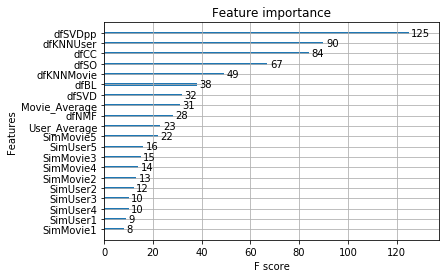

In [224]:
xgb.plot_importance(model)


In [242]:
ids, preds = u.predict_on_models_xgb([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],df_sub_load_on_full_dataset,model)

In [243]:
list_prds=[]
for i in preds:
    list_prds.append(int(round(i[0])))
    
u.create_csv_submission(ids, list_prds, "submissionBlendedFull.csv")


## Boosting with surprise models only

In [439]:
# for xgboosting
df_val=pd.concat([dfCC,dfSVDpp,dfKNNMovie,dfKNNUser],ignore_index=True,axis=1)
df_val=df_val.rename({0:'dfCC',1:'dfSVDpp',2:'dfKNNMovie',3:'dfKNNUser'},axis=1)

In [440]:
model2= xgb.XGBRegressor(silent=True, n_jobs=4, random_state=1,n_estimators=100)

model2.fit(df_val,y_val, eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

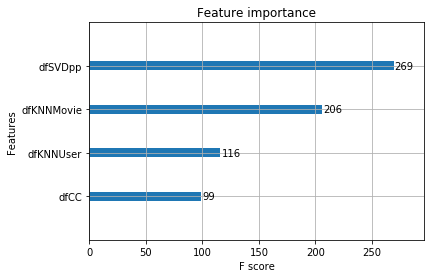

In [441]:
xgb.plot_importance(model2)

In [443]:
import utils as u
ids, preds = u.predict_on_models_xgb_old([algoCC, algoSVDpp,algoKNNMovie,algoKNNUser],model2)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


In [448]:
list_prds=[]
for i in preds:
    list_prds.append(int(round(i[0])))
    
u.create_csv_submission(ids, list_prds, "submissionBlendedSurpriseOnlyFewModels.csv")

## Try one model only

In [ ]:
blended all- 1.058
blended surprise only -1.056
blended minimize surprise only -1.061
svdpp-1.059
svd-1.059 (new: 	1.045)
knnuser- 1.074
knnmovie- 1.078
so-1.060

In [293]:
ids, preds =u.predict_on_model(algoSO)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000


In [294]:
u.create_csv_submission(ids, preds, "submissionSO.csv")

## our own Blending case

In [264]:
from sklearn.linear_model import LogisticRegression

df_val=pd.concat([dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO],axis=1)


# model = LogisticRegression(multi_class='multinomial',solver ='newton-cg')
model = LogisticRegression(multi_class='ovr')
model.fit(df_val,y_val)
print("Check classes:",model.classes_)
print(model.coef_)



//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Check classes: [1. 2. 3. 4. 5.]
[[-1.07464777e+00  1.11139912e+00  2.02967935e-02 -1.76004308e+00
   4.53604552e-02 -5.67844678e-02 -2.86790739e-01 -8.72718902e-02]
 [-7.55730329e-01  1.26797560e+00  1.24639501e-01 -1.30559942e+00
  -6.10622515e-02  3.39840726e-02 -6.13582985e-01 -4.00109478e-01]
 [-2.37027135e-01  1.11634339e+00  3.51167167e-01 -6.77209722e-01
  -1.82977835e-01 -1.44300218e-01 -2.84786797e-01 -1.07338172e+00]
 [ 8.34977113e-01 -1.54381693e-02  1.14898049e+00 -1.36206374e-03
  -1.33880948e-01  1.41087381e-01 -6.05193457e-02 -1.74475837e+00]
 [-4.28691594e-02 -3.63025516e+00 -9.22476799e-01  1.27349052e+00
   1.59169244e-02  2.08962415e-01  7.20029089e-01  4.32213263e+00]]


In [180]:
ids, preds = u.predict_on_models([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlended6.csv")

In [268]:
ids, preds = u.predict_on_models2([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],model.coef_)
u.create_csv_submission(ids, preds, "submissionBlendedOurs.csv")

KeyboardInterrupt: 

## Blending with minimize

In [430]:
def compute_mse(real_ratings, predictions):
    """
    Computes the Mean Squared Error given the real and the predicted
    ratings.
    Args:
        real_ratings: The actual ratings
        predictions: Ratings predicted by some model
    Returns:
        mse: The Mean Squared Error value
    """
    error_vector = real_ratings - predictions
    return np.mean(error_vector ** 2)

def compute_rmse(real_ratings, predictions):
    """
    Computes the Root Mean Squared Error given the real and the
    predicted ratings.
    Args:
        real_ratings: The actual ratings
        predictions: Ratings predicted by some model
    Returns:
        rmse: The Root Mean Squared Error value
    """
    rmse = np.sqrt(compute_mse(real_ratings, predictions))
    return rmse

In [431]:
weights=[1/8]*8
models_predictions_on_test=[dfCC,dfBL,dfSVD,dfSVDpp,dfNMF,dfKNNMovie,dfKNNUser,dfSO]

In [432]:
def new_blending():
    result = minimize(fun=objective_function,
                          x0=weights,
                          method='SLSQP')
    print(result)
    return result.x

In [433]:
weights

[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]

In [434]:
def objective_function(weights):
        """
        Objective function to be optimized. The function is indeed the Root Mean 
        Squared Error of the weighted combination of prediction results of each model.
        Args:
            weights: A list containing the individual weights of each model
        """
        mixed_models = 0
        for i in range(len(models_predictions_on_test)):
            mixed_models += weights[i] * models_predictions_on_test[i]
        rmse = compute_rmse(df_y_val, mixed_models)
        return rmse

In [435]:
from scipy.optimize import minimize

result=new_blending()

     fun: 0.9779873536255348
     jac: array([ 8.02874565e-05, -1.97209418e-04, -1.63778663e-04,  2.48625875e-05,
       -2.32532620e-04,  2.12647021e-04, -2.54340470e-04,  7.30752945e-05])
 message: 'Optimization terminated successfully.'
    nfev: 293
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([-0.02147561,  0.08594459,  1.05667548, -0.68997904, -0.02374998,
        0.1163467 ,  0.02365167,  0.45179959])


In [436]:
ids, preds=u.predict_on_models([algoCC, algoBL,algoSVD, algoSVDpp,algoNMF,algoKNNMovie,algoKNNUser,algoSO],result)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000


In [438]:
u.create_csv_submission(ids, preds, "submissionBlendedMinimize.csv")

In [427]:
file_name = 'y_df.pk'
df_y_val.to_pickle(file_name)  
df = pd.read_pickle(file_name)